In [2]:
# Data from https://grouplens.org/datasets/movielens/latest/
# Put the downloaded csv files in the "Downloads" folder

import os
os.chdir("Downloads")
print(os.getcwd())


c:\Users\vonks\Documents\GitHub\Movie_Recs\Downloads


In [3]:
import pandas as pd

ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

data = ratings.merge(movies, on="movieId", how="left")

# Filtering if necessary here

filtered_data = data

In [4]:
print(data.head(1))
#print(data.info())

print("# Users:", data['userId'].nunique())
print("# Movies:", data['movieId'].nunique())
print("# Ratings:", len(data))


   userId  movieId  rating   timestamp             title  \
0       1        1     4.0  1225734739  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
# Users: 330975
# Movies: 83239
# Ratings: 33832162


## Data Exploration

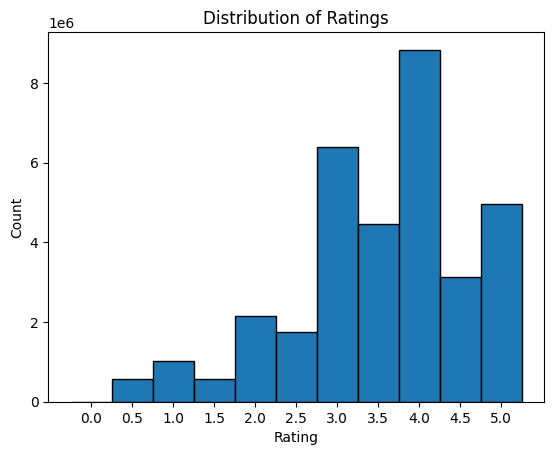

In [5]:
import numpy as np
import matplotlib.pyplot as plt

ratings = np.arange(0, 5.5, 0.5)  # Going to 5.5 to include the 5 bin

# Using np.histogram for time efficiency because data is large
counts, edges = np.histogram(data['rating'], bins=np.arange(-0.25, 5.25 + 0.5, 0.5))

plt.bar(ratings, counts, width=0.5, edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.xticks(ratings)
plt.show()


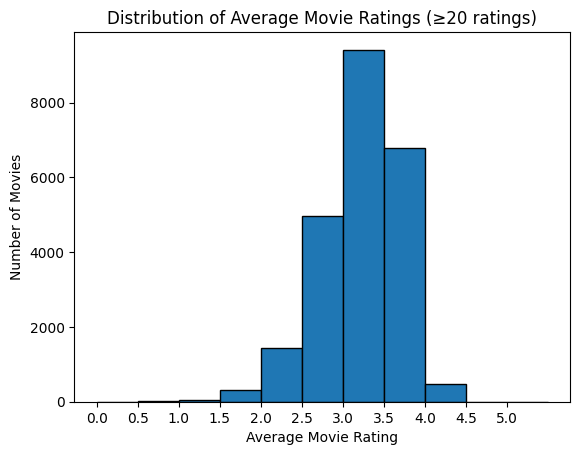

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Filter movies with >=20 ratings
movie_counts = filtered_data.groupby('movieId').size()
movies_with_enough_ratings = movie_counts[movie_counts >= 20].index
filtered_movies_data = filtered_data[filtered_data['movieId'].isin(movies_with_enough_ratings)]

# Compute average rating per movie after filtering
avg_ratings = filtered_movies_data.groupby('movieId')['rating'].mean().values

# Define bins of width 0.5
bin_width = 0.5
bins = np.arange(0, 5.5 + bin_width, bin_width)  # 0 to 5 in steps of 0.5

# Compute histogram
counts, edges = np.histogram(avg_ratings, bins=bins)

# Compute bin centers for centering bars
bin_centers = edges[:-1] + bin_width / 2

# Plot
plt.bar(bin_centers, counts, width=bin_width, edgecolor='black', align='center')
plt.xlabel("Average Movie Rating")
plt.ylabel("Number of Movies")
plt.title("Distribution of Average Movie Ratings (≥20 ratings)")
plt.xticks(np.arange(0, 5.5, 0.5))
plt.show()


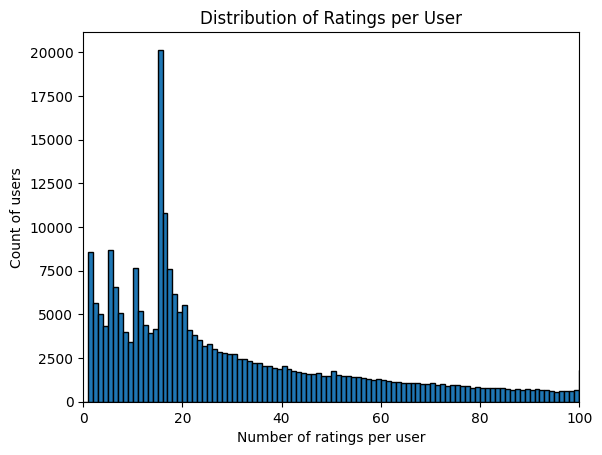

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Count how many ratings each user has
ratings_per_user = filtered_data.groupby('userId').size().values

max_ratings = min(100, ratings_per_user.max())
bins = np.arange(0, max_ratings + 2, 1)

counts, edges = np.histogram(ratings_per_user, bins=bins)

# Barplot
plt.bar(edges[:-1], counts, width=1, edgecolor='black', align='edge')
plt.xlabel("Number of ratings per user")
plt.ylabel("Count of users")
plt.title("Distribution of Ratings per User")
plt.xlim(0, max_ratings)
plt.show()


## User Similarity Recommendation

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Parameters
min_ratings_per_user = 20 # For selection of active users
sample_size = 100
K = 10 # Number of recommendations
liked_threshold = 4
top_n_input = 4 # Number of liked movies to use for similarity

# Select active users
active_users = filtered_data.groupby('userId').size()
active_users = active_users[active_users >= min_ratings_per_user].index

# Random sample of users because data is large
np.random.seed(123)
sampled_users = np.random.choice(active_users, size=sample_size, replace=False)

# For each sampled user, split their movie ratings into train (80%) and test (20%)
train_ratings = pd.DataFrame()
test_ratings = pd.DataFrame()

for uid in sampled_users:
    user_data = filtered_data[filtered_data['userId'] == uid]
    train, test = train_test_split(user_data, test_size=0.2, random_state=42)
    train_ratings = pd.concat([train_ratings, train])
    test_ratings = pd.concat([test_ratings, test])

# -----------------------------
# Build matrix from training data
# -----------------------------
user_ids = train_ratings['userId'].unique()
movie_ids = train_ratings['movieId'].unique()
user_to_idx = {uid:i for i, uid in enumerate(user_ids)} # Rows
movie_to_idx = {mid:i for i, mid in enumerate(movie_ids)} # Columns

# Empty matrix
n_users = len(user_ids)
n_movies = len(movie_ids)
user_item_matrix = np.zeros((n_users, n_movies))

# Fill matrix
for row in train_ratings.itertuples():
    u_idx = user_to_idx[row.userId]
    m_idx = movie_to_idx[row.movieId]
    user_item_matrix[u_idx, m_idx] = row.rating

# -----------------------------
# Generate recommendations using only top liked movies
# -----------------------------
user_metrics = []

for uid in sampled_users:
    u_idx = user_to_idx[uid]
    user_vector = user_item_matrix[u_idx, :] # Ratings

    # Select top-N liked movies only (positive ratings)
    liked_indices = np.where(user_vector >= liked_threshold)[0]
    if len(liked_indices) == 0:
        continue
    
    top_indices = np.argsort(user_vector[liked_indices])[-top_n_input:]
    top_indices = liked_indices[top_indices]

    # Find relevant users who rated at least one of these top-N movies
    rel_users = np.any(user_item_matrix[:, top_indices] > 0, axis=1)
    rel_users[u_idx] = False
    relevant_users_matrix = user_item_matrix[rel_users, :]

    if relevant_users_matrix.shape[0] == 0:
        continue

    # Cosine similarity on top-N liked movies
    sims = cosine_similarity([user_vector[top_indices]], relevant_users_matrix[:, top_indices])[0]

    # Compute weighted average for unseen movies based on similar users = prediction
    unseen = np.where(user_vector == 0)[0]
    weighted_scores = np.zeros(len(unseen))
    for i, m_idx in enumerate(unseen):
        weighted_scores[i] = np.sum(relevant_users_matrix[:, m_idx] * sims) / (np.sum(sims) + 1e-8)

    # Top recommendations
    top_recs_idx = np.argsort(weighted_scores)[::-1][:K] # Top K
    recommended_movie_ids = [list(movie_to_idx.keys())[unseen[i]] for i in top_recs_idx]

    # Test set 
    test_all = test_ratings[test_ratings['userId'] == uid]
    test_liked = set(test_all[test_all['rating'] >= liked_threshold]['movieId'])
    test_not_liked = set(test_all[test_all['rating'] < liked_threshold]['movieId'])

    user_metrics.append({
        'recommended': recommended_movie_ids,
        'test_liked': test_liked,
        'test_not_liked': test_not_liked
    })


In [ ]:
import pandas as pd
import numpy as np

all_movie_ids = set(filtered_data['movieId'].unique())
K = 10  # top-K recommendations
liked_threshold = 4.0

counts_per_user = []
hit_rates, precisions, recalls = [], [], []

#filtered_user_metrics = [um for um in user_metrics if len(um['test_liked']) > 0]

for um in user_metrics:
    # Unpack the information per user (um)
    recommended = set(um['recommended'])
    test_liked = um['test_liked']
    test_not_liked = um['test_not_liked']
    test_movies = test_liked | test_not_liked

    # Metrics for table
    rec_watched_liked = len(recommended & test_liked)
    rec_watched_not_liked = len(recommended & test_not_liked)
    rec_not_watched = len(recommended - test_movies)

    nonrec = all_movie_ids - recommended
    nonrec_watched_liked = len(nonrec & test_liked)
    nonrec_watched_not_liked = len(nonrec & test_not_liked)
    nonrec_not_watched = len(nonrec - test_movies)

    counts_per_user.append({
        'Recommended_Watched+Liked': rec_watched_liked,
        'Recommended_Watched+NotLiked': rec_watched_not_liked,
        'Recommended_NotWatched': rec_not_watched,
        'NotRecommended_Watched+Liked': nonrec_watched_liked,
        'NotRecommended_Watched+NotLiked': nonrec_watched_not_liked,
        'NotRecommended_NotWatched': nonrec_not_watched
    })

    # Hit Rate = 1 if at least one liked movie is recommended
    #hit = 1 if len(recommended & test_liked) > 0 else 0
    hit = len(recommended & test_liked) / len(test_liked) if len(test_liked) > 0 else 0

    # Precision and Recall K
    precision = len(recommended & test_liked) / len(recommended) if len(recommended) > 0 else 0
    recall = len(recommended & test_liked) / len(test_liked) if len(test_liked) > 0 else 0
    
    hit_rates.append(hit)
    precisions.append(precision)
    recalls.append(recall)

# Table with averages
counts_df = pd.DataFrame(counts_per_user)
average_counts = counts_df.mean()

table = pd.DataFrame({
    'Recommended': [
        average_counts['Recommended_Watched+Liked'],
        average_counts['Recommended_Watched+NotLiked'],
        average_counts['Recommended_NotWatched']
    ],
    'Not Recommended': [
        average_counts['NotRecommended_Watched+Liked'],
        average_counts['NotRecommended_Watched+NotLiked'],
        average_counts['NotRecommended_NotWatched']
    ]
}, index=['Liked', 'Not Liked', 'Not Watched'])

# Add totals column
table['Total'] = table['Recommended'] + table['Not Recommended']

print("Recommendations based on user similarity of liked movies:")
print(table)

avg_hit_rate = np.mean(hit_rates)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

print("\nAverage metrics:")
print(f"Fraction of liked movies recommended in {K} recs: {avg_hit_rate:.3f}")
print(f"Precision in {K} recs: {avg_precision:.3f}")
print(f"Recall in {K} recs: {avg_recall:.3f}")


Recommendations based on user similarity of liked movies:
             Recommended  Not Recommended         Total
Liked           1.041237        14.587629     15.628866
Not Liked       0.391753        12.082474     12.474227
Not Watched     8.567010     83202.329897  83210.896907

Average metrics:
Hit Rate in 10 recs: 0.095
Precision in 10 recs: 0.104
Recall in 10 recs: 0.095


## Recommending based on top 10 rated movies overall

In [14]:
import pandas as pd
import numpy as np

all_movie_ids = set(filtered_data['movieId'].unique())
K = 10
liked_threshold = 4
min_ratings_per_movie = 20

# Top average movies
# First filter movies with at least 20 ratings
movie_counts = train_ratings.groupby('movieId').size()
eligible_movies = movie_counts[movie_counts >= min_ratings_per_movie].index
filtered_ratings = train_ratings[train_ratings['movieId'].isin(eligible_movies)]
filtered_movies = filtered_ratings.groupby('movieId')['rating'].agg(['mean', 'count'])
top_movies_by_avg = filtered_movies.sort_values('mean', ascending=False).head(K).index.tolist()

# Calculate metrics for each user
user_metrics_baseline = []

for uid in sampled_users:
    recommended = set(top_movies_by_avg)

    test_all = test_ratings[test_ratings['userId'] == uid]
    test_liked = set(test_all[test_all['rating'] >= liked_threshold]['movieId'])
    test_not_liked = set(test_all[test_all['rating'] < liked_threshold]['movieId'])

    user_metrics_baseline.append({
        'recommended': recommended,
        'test_liked': test_liked,
        'test_not_liked': test_not_liked
    })

# Calculate counts and metrics
counts_per_user = []
hit_rates, precisions, recalls = [], [], []

for um in user_metrics_baseline:
    recommended = set(um['recommended'])
    test_liked = um['test_liked']
    test_not_liked = um['test_not_liked']
    test_movies = test_liked | test_not_liked

    rec_watched_liked = len(recommended & test_liked)
    rec_watched_not_liked = len(recommended & test_not_liked)
    rec_not_watched = len(recommended - test_movies)

    nonrec = all_movie_ids - recommended
    nonrec_watched_liked = len(nonrec & test_liked)
    nonrec_watched_not_liked = len(nonrec & test_not_liked)
    nonrec_not_watched = len(nonrec - test_movies)

    counts_per_user.append({
        'Recommended_Watched+Liked': rec_watched_liked,
        'Recommended_Watched+NotLiked': rec_watched_not_liked,
        'Recommended_NotWatched': rec_not_watched,
        'NotRecommended_Watched+Liked': nonrec_watched_liked,
        'NotRecommended_Watched+NotLiked': nonrec_watched_not_liked,
        'NotRecommended_NotWatched': nonrec_not_watched
    })

    hit_rates.append(len(recommended & test_liked) / len(test_liked) if len(test_liked) > 0 else 0)
    precisions.append(rec_watched_liked / K)
    recalls.append(rec_watched_liked / len(test_liked) if len(test_liked) > 0 else 0)

# Table
counts_df = pd.DataFrame(counts_per_user)
avg_counts = counts_df.mean()
table = pd.DataFrame({
    'Recommended': [
        avg_counts['Recommended_Watched+Liked'],
        avg_counts['Recommended_Watched+NotLiked'],
        avg_counts['Recommended_NotWatched']
    ],
    'Not Recommended': [
        avg_counts['NotRecommended_Watched+Liked'],
        avg_counts['NotRecommended_Watched+NotLiked'],
        avg_counts['NotRecommended_NotWatched']
    ]
}, index=['Watched + Liked', 'Watched + Not Liked', 'Not Watched'])

table['Total'] = table['Recommended'] + table['Not Recommended']

# Average metrics
avg_hit_rate = np.mean(hit_rates)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

print("Recommendations based on top average movie ratings:")
print(table)
print("\nMetrics:")
print(f"Fraction of liked movies recommended in {K} recs: {avg_hit_rate:.3f}")
print(f"Precision in {K} recs: {avg_precision:.3f}")
print(f"Recall in {K} recs: {avg_recall:.3f}")

# Top 10 movies (recommended)
print("\nTop 10 movies by average rating (min 20 ratings):")
for i, movieId in enumerate(top_movies_by_avg, start=1):
    title = movies.loc[movies['movieId'] == movieId, 'title'].values[0]
    avg_rating = filtered_movies.loc[movieId, 'mean']
    n_ratings = filtered_movies.loc[movieId, 'count']
    print(f"{i}. {title} (average rating: {avg_rating:.2f}, n_ratings: {n_ratings})")


Recommendations based on top average movie ratings:
                     Recommended  Not Recommended     Total
Watched + Liked             0.65            15.65     16.30
Watched + Not Liked         0.17            12.56     12.73
Not Watched                 9.18         83200.79  83209.97

Metrics:
Fraction of liked movies recommended in 10 recs: 0.060
Precision in 10 recs: 0.065
Recall in 10 recs: 0.060

Top 10 movies by average rating (min 20 ratings):
1. Shawshank Redemption, The (1994) (average rating: 4.50, n_ratings: 38)
2. Fight Club (1999) (average rating: 4.44, n_ratings: 26)
3. Dark Knight, The (2008) (average rating: 4.37, n_ratings: 23)
4. Pulp Fiction (1994) (average rating: 4.34, n_ratings: 37)
5. Silence of the Lambs, The (1991) (average rating: 4.28, n_ratings: 44)
6. Schindler's List (1993) (average rating: 4.27, n_ratings: 31)
7. Godfather, The (1972) (average rating: 4.27, n_ratings: 28)
8. Seven (a.k.a. Se7en) (1995) (average rating: 4.25, n_ratings: 24)
9. Americ